In [3]:
# Basic import
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')
# - Astrobject Modules
import astrobject as a

# This is a Test of Astropy Modeling.

This notebook starts by showing how astropy modeling works following examples from http://docs.astropy.org/en/stable/modeling/. 

In a Second times, we fit 2D data to show the ability of astropy modeling to fit real data: 

* A fake 2D gaussian
* A real g-band star observation from SDSS.
  * The star is fitted either by a gaussian
  * or a Moffat profile

***

## Astropy Example: The 1D gaussian example

Generate the Data

In [4]:
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

Fit the data using a box model

In [5]:
t_init = models.Trapezoid1D(amplitude=1., x_0=0., 
                            width=1., slope=0.5)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)


Fit the data using a Gaussian

In [6]:
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

Plot the data with the best-fit model

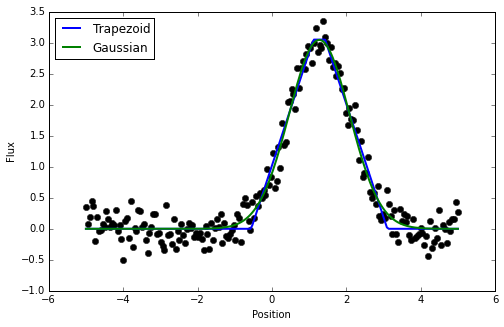

In [7]:
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, t(x), lw=2,label='Trapezoid')
plt.plot(x, g(x), lw=2,label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)

## Astropy Example: Combining models the bimodal test

Generate fake data

In [8]:
np.random.seed(42)
g1 = models.Gaussian1D(1, 0, 0.2)
g2 = models.Gaussian1D(2.5, 0.5, 0.1)
x = np.linspace(-1, 1, 200)
y = g1(x) + g2(x) + np.random.normal(0., 0.2, x.shape)

**Now to fit the data create a new superposition with initial guesses for the parameters**


In [9]:
g1_init = models.Gaussian1D(1, 0, 0.1)
g2_init = models.Gaussian1D(2, 0.5, 0.1)
gg_init = g1_init + g2_init # Could have done it directly too.
fitter = fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, x, y)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.83285936044
            Iterations: 14
            Function evaluations: 137
            Gradient evaluations: 14


Plot the data with the best-fit model

<CompoundModel0(amplitude_0=0.9811849432625771, mean_0=0.005977417678848472, stddev_0=0.20739114482536675, amplitude_1=2.485654775694356, mean_1=0.5041218550429216, stddev_1=0.09999958370673168)>

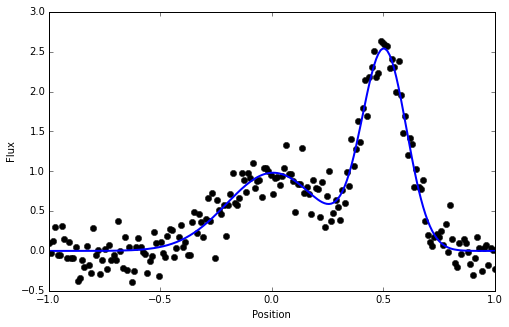

In [10]:
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, gg_fit(x), lw=2)
plt.xlabel('Position')
plt.ylabel('Flux')
gg_fit

# The 2D fitting. On the road to PSF fitting

## Astropy Example: The polynomial background
Generate fake data

In [11]:
np.random.seed(0)
y, x = np.mgrid[:128, :128]
z = 2. * x ** 2 - 0.5 * x ** 2 + 1.5 * x * y - 1.
z += np.random.normal(0., 0.1, z.shape) * 50000.


Fit the data using
astropy.modeling. Models will be a second order polynomial

In [12]:
p_init = models.Polynomial2D(degree=2)
fit_p = fitting.LevMarLSQFitter()

In [13]:
p = fit_p(p_init, x, y, z)

Plot the data with the best-fit model

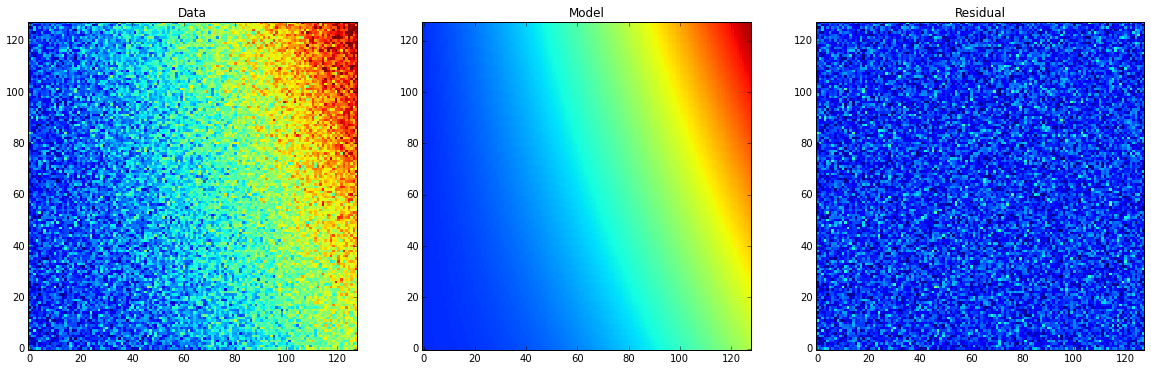

In [14]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest', vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Residual")

## Gaussian Fit on Fake Data

First, creates the fake data

In [15]:
from scipy import stats

In [16]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = stats.multivariate_normal([0.5, -0.3], [[.8, 0.], [0., .8]])
gauss2d = rv.pdf(pos) 
gauss2d += np.random.normal(0., 0.05, gauss2d.shape)


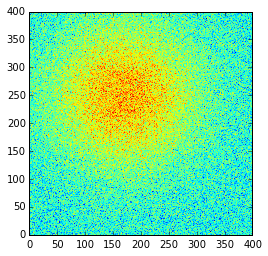

In [17]:
plt.imshow(gauss2d, origin='lower', interpolation='nearest')

In [18]:
p_init = models.Gaussian2D(amplitude=1,x_mean=0,y_mean=0,
                           cov_matrix=[[1.0,0],[0,1.0]])
fit_p = fitting.LevMarLSQFitter()
p = fit_p(p_init, x, y, gauss2d)

Plot The data with best-fit model

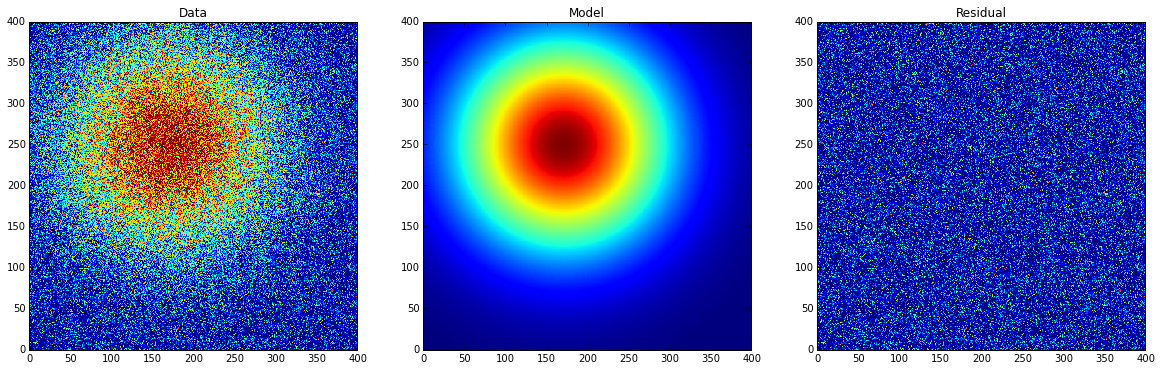

In [19]:
plt.figure(figsize=(20, 10))
prop = dict(origin='lower', interpolation='nearest',
           vmax=0.2,vmin=0.001)
plt.subplot(1, 3, 1)
plt.imshow(gauss2d, **prop)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), **prop)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow((gauss2d - p(x, y)), **prop)
plt.title("Residual")


# Fitting Real Data

We are going to fit real data on SDSS images

In [20]:
sdss = a.get_instrument("data/sdss_PTF10qjq_g.fits")

In [21]:
data = sdss.data[950:1000,730:780]
prop = dict(origin='lower', interpolation='nearest')
pos_guess = [20,30]

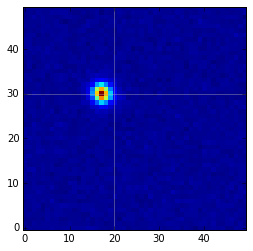

In [22]:
plt.imshow(data,**prop)
plt.axvline(pos_guess[0], color="0.7", alpha=0.4)
plt.axhline(pos_guess[1], color="0.7", alpha=0.4)

### Fit data using Gaussian2d

In [23]:
y, x = np.mgrid[:50, :50]
p_init = models.Gaussian2D(amplitude=1,x_mean=pos_guess[0],y_mean=pos_guess[1],
                           cov_matrix=[[1.0,0],[0,1.0]])
fit_p = fitting.LevMarLSQFitter()

In [24]:
p = fit_p(p_init, x, y, data)

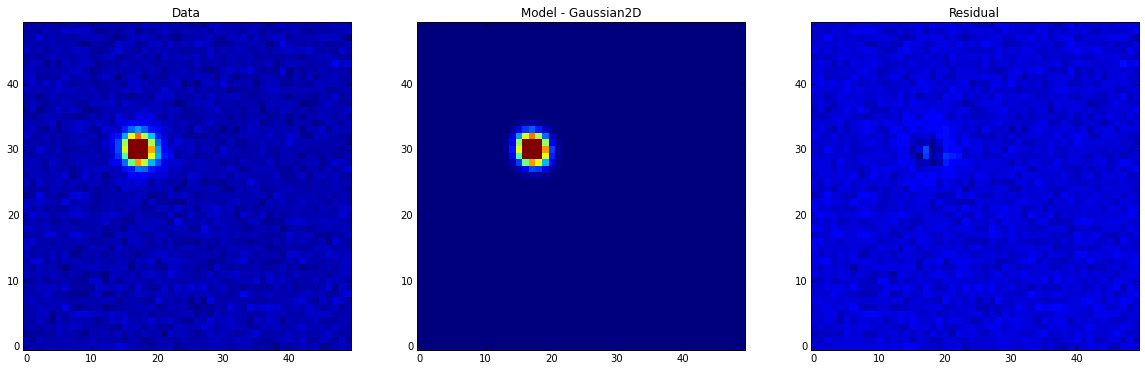

In [25]:
plt.figure(figsize=[20,10])
plt.subplot(1, 3, 1)
prop["vmax"]=1
plt.imshow(data, **prop)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), **prop)
plt.title("Model - Gaussian2D")
plt.subplot(1, 3, 3)
plt.imshow((data - p(x, y)), **prop)
plt.title("Residual")

In [26]:
p

<Gaussian2D(amplitude=2.1782371700792287, x_mean=17.07328721502423, y_mean=30.020575531017762, x_stddev=1.2899737822890207, y_stddev=1.4168091529928872, theta=0.5035821250965192)>

### Fit data using Moffat2d

In [27]:
p_init = models.Moffat2D(amplitude=1,x_0=pos_guess[0],y_0=pos_guess[1],gamma=1,alpha=2)
fit_p = fitting.LevMarLSQFitter()
p = fit_p(p_init, x, y, data)

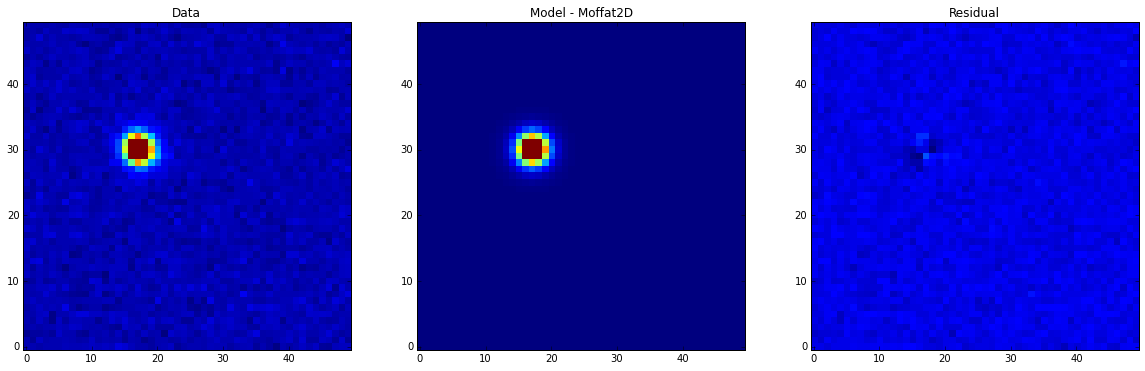

In [28]:
plt.figure(figsize=[20,10])
plt.subplot(1, 3, 1)
prop["vmax"]=1
plt.imshow(data, **prop)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), **prop)
plt.title("Model - Moffat2D")
plt.subplot(1, 3, 3)
plt.imshow((data - p(x, y)), **prop)
plt.title("Residual")

In [29]:
p

<Moffat2D(amplitude=2.317768224722477, x_0=17.07206125809667, y_0=30.016085338475424, gamma=3.4252997689612625, alpha=4.12755321399353)>

# Fitting Several Stars

In [196]:
sdss = a.get_instrument("data/sdss_PTF10qjq_g.fits", dataslice0 = [1200,1400],dataslice1 = [400,700])

In [197]:
sdss.download_catalogue()

{'rmag': '5..25'}


In [198]:
sdss.sep_extract()

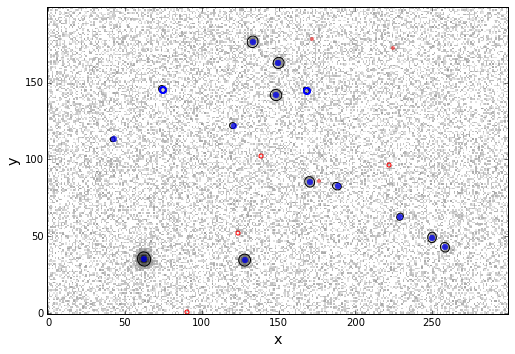

In [199]:
pl = sdss.show(show_catalogue=True, show_sepobjects=True)

In [200]:
sepmaskstars = sdss.sepobjects.get_indexes(stars_only=True)

In [216]:
xcoords,ycoords,flux = sdss.sepobjects.get(["x","y","flux"],mask=sepmaskstars).T

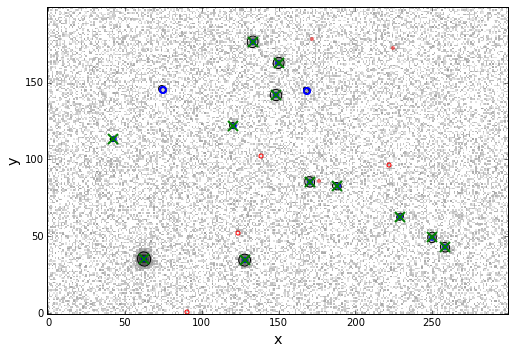

In [217]:
pl = sdss.show(show_catalogue=True, show_sepobjects=True)
sdss._plot["ax"].plot(xcoords,ycoords,ls="None", marker="x",ms=10,mew=2,lw=2,color="g", scaley=False, scalex=False)

### Now Let's define the model that is a Moffat2D for each of these stars

The unit value will enable us to provide more precise inutial guess to the moffat profile

In [243]:
unit = sdss.data.max()/ flux.max() ; print unit

0.0820135513669


As Initial guess for gamma: sep psf

In [244]:
psf_pix = sdss.sepobjects.get_fwhm_pxl()

In [245]:
boundaries = {"amplitude":[0,None],"gamma":[1,psf_pix*10],"alpha":[1,10]}
coords_bounds = {"x_0":[xcoords[0]-2,xcoords[0]+2],"y_0":[ycoords[0]-2,ycoords[0]+2]}

p_init = models.Moffat2D(amplitude=flux[0]*unit,x_0=xcoords[0],y_0=ycoords[0],gamma=psf_pix*2,alpha=2,
                        bounds=a.utils.tools.kwargs_update(boundaries,**coords_bounds))
def tiedgamma(g):
    return g.gamma_0

def tiedalpha(g):
    return g.alpha_0

for f_,x_,y_ in zip(flux[1:],xcoords[1:],ycoords[1:]):
    coords_bounds = {"x_0":[x_-2,x_+2],"y_0":[y_-2,y_+2]}
    p_init += models.Moffat2D(amplitude=f_*unit,x_0=x_,y_0=y_,gamma=psf_pix*2,alpha=2,
                              bounds=a.utils.tools.kwargs_update(boundaries,**coords_bounds),
                              tied={"gamma":tiedgamma,"alpha":tiedalpha})

fit_p = fitting.SLSQPLSQFitter()

In [247]:
y, x = np.mgrid[:sdss.height, :sdss.width]
p = fit_p(p_init, x, y, sdss.data)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.0684931245
            Iterations: 68
            Function evaluations: 2745
            Gradient evaluations: 68


[[<matplotlib.lines.Line2D at 0x12ad6da50>],

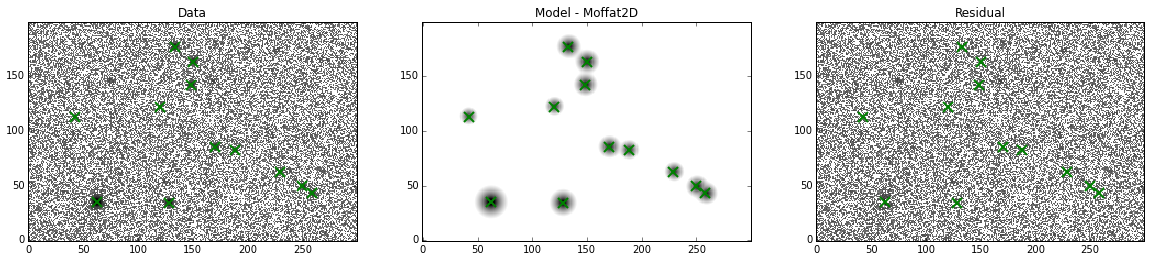

In [248]:
fig = plt.figure(figsize=[20,10])
prop = dict(origin="lower", interpolation="nearest", vmin=-5,vmax=0, cmap=plt.cm.binary)

# - Data
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(np.log10(sdss.data), **prop)
ax1.set_title("Data")

# - Model
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(np.log10(p(x, y)), **prop)
ax2.set_title("Model - Moffat2D")

# - Residual
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(np.log10(sdss.data - p(x, y)), **prop)
ax3.set_title("Residual")

[ax.plot(xcoords,ycoords,ls="None", marker="x",ms=10,mew=2,lw=2,color="g", scaley=False, scalex=False)
for ax in [ax1,ax2,ax3]]